# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [38]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

We set the random seed so that the results don't vary drastically.

In [39]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [40]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20
num_classes = 5
img_rows, img_cols =100,100
input_shape = (30,img_rows, img_cols, 3)

In [41]:
train_doc.size

663

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [42]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(folder_list.size/batch_size)
        print('num_batches:'+str(num_batches)+', folder_list.size:'+str(folder_list.size))
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,img_rows,img_cols,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
#                 print(folder)
#                 print(t[folder + (batch*batch_size)])
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image=imresize(image, (100,100))
                    image=image/255.0
                    batch_data[folder,idx,:,:,0] = image[:, : , 0]
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        if(folder_list.size%batch_size>0):
#            print('remaining')
            batch_data = np.zeros((batch_size,30,img_rows,img_cols,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(folder_list.size%batch_size): # iterate over the batch_size
#                 print(folder)
#                 print(folder + (batch*batch_size))
#                 print(folder + ((num_batches)*batch_size))
                imgs = os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + ((num_batches)*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image=imresize(image, (100,100))
                    image=image/255.0
                    batch_data[folder,idx,:,:,0] = image[:, : , 0]
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [43]:
#a = generator('Project_data/train', train_doc, batch_size)

In [44]:
# for i in generator('Project_data/train', train_doc, batch_size):
#     print(i)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [45]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [46]:
input_shape

(30, 100, 100, 3)

In [47]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers

#try different parameters
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3),activation = 'relu'), input_shape=input_shape))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
print(model.output_shape)
model.add(TimeDistributed(Conv2D(16, (3,3),activation = 'relu')))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
print(model.output_shape)
model.add(TimeDistributed(Conv2D(32, (3,3),activation = 'relu')))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
print(model.output_shape)
model.add(TimeDistributed(Conv2D(64, (3,3),activation = 'relu')))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
print(model.output_shape)
model.add(TimeDistributed(Flatten()))
print(model.output_shape)
#define LSTM model
model.add(Dropout(0.4))
model.add(LSTM(128,return_sequences=False, dropout=0.4))
print(model.output_shape)
model.add(Dense(num_classes, activation='softmax'))
print(model.output_shape)

(None, 30, 98, 98, 8)
(None, 30, 49, 49, 8)
(None, 30, 47, 47, 16)
(None, 30, 23, 23, 16)
(None, 30, 21, 21, 32)
(None, 30, 10, 10, 32)
(None, 30, 8, 8, 64)
(None, 30, 4, 4, 64)
(None, 30, 1024)
(None, 128)
(None, 5)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [48]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.build(input_shape)
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 30, 98, 98, 8)     224       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 49, 49, 8)     0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 47, 47, 16)    1168      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 23, 23, 16)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 21, 21, 32)    4640      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 10, 10, 32)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 8, 8, 64)      18496     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [49]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
train_generator

<generator object generator at 0x000001FE82454EB8>

In [51]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3,verbose=1,
                              patience=5, min_lr=0.0001)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [53]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
Source path =  Project_data/val ; batch size = 20
num_batches:5, folder_list.size:100
Source path =  Project_data/train ; batch size = 20
num_batches:33, folder_list.size:663


C:\Users\reddi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
C:\Users\reddi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 6s - loss: 1.5898 - categorical_accuracy: 0.2359 

C:\Users\reddi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\reddi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 116s 3s/step - loss: 1.5457 - categorical_accuracy: 0.2324 - val_loss: 1.5094 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-02-0818_15_45.617111/model-00001-1.54567-0.23235-1.50945-0.37000.h5
Epoch 2/15
34/34 [==============================] - 104s 3s/step - loss: 1.3288 - categorical_accuracy: 0.4441 - val_loss: 1.3427 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2020-02-0818_15_45.617111/model-00002-1.32878-0.44412-1.34270-0.46000.h5
Epoch 3/15
34/34 [==============================] - 104s 3s/step - loss: 1.0188 - categorical_accuracy: 0.5868 - val_loss: 1.0406 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2020-02-0818_15_45.617111/model-00003-1.01878-0.58676-1.04064-0.63000.h5
Epoch 4/15
34/34 [==============================] - 105s 3s/step - loss: 0.8591 - categorical_accuracy: 0.6441 - val_loss: 1.0935 - val_categorical_accuracy: 0.6000

Epoch 00

In [54]:
#history.history

C:\Users\reddi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\reddi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
C:\Users\reddi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


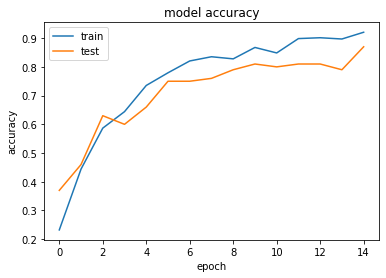

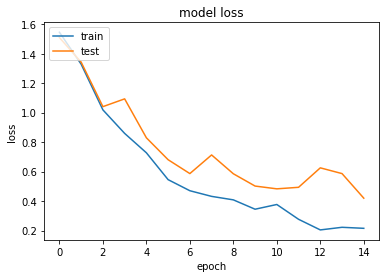

In [55]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()